### TODO 二倍体和四倍体windows在每个材料中与基因的交集
+ 根据频率区分的windows在每份材料中与gene取交集

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(ggbeeswarm)

In [11]:
All_window_overlapGene <- read.table(
    "./geneticRegionAnnotation/All_50Sample_overlapGenetic.txt",
    header = T
)
All_window_overlapGene$windowType <- factor(
    All_window_overlapGene$windowType,
    levels = c(
        "Core", "softCore", "dispensable", "Private"
    )
)

In [12]:
plotData <- All_window_overlapGene %>%
    mutate(
        containRatio = contained / total,
        noOverlapRatio = noOverlap / total
    ) %>%
    pivot_longer(
        cols = c("containRatio", "noOverlapRatio"),
        values_to = "seqRatio",
        names_to = "geneRegion"
    ) %>% mutate(
        type2=paste(windowType,geneRegion,sep="_")
    )
head(plotData)

Sample,windowType,total,contained,noOverlap,overlap,geneRegion,seqRatio,type2
<fct>,<fct>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<chr>
DC001,Core,1055800158,617651003,371088488,67060667,containRatio,0.5850075,Core_containRatio
DC001,Core,1055800158,617651003,371088488,67060667,noOverlapRatio,0.3514761,Core_noOverlapRatio
DC001,Private,2695706,818019,1872255,5432,containRatio,0.3034526,Private_containRatio
DC001,Private,2695706,818019,1872255,5432,noOverlapRatio,0.6945323,Private_noOverlapRatio
DC001,dispensable,524183636,182802955,296384795,44995886,containRatio,0.3487384,dispensable_containRatio
DC001,dispensable,524183636,182802955,296384795,44995886,noOverlapRatio,0.5654217,dispensable_noOverlapRatio


In [15]:
#* 进行统计检验
plotData %>% count(type2)

type2,n
<chr>,<int>
Core_containRatio,50
Core_noOverlapRatio,50
Private_containRatio,49
Private_noOverlapRatio,49
dispensable_containRatio,50
dispensable_noOverlapRatio,50
softCore_containRatio,50
softCore_noOverlapRatio,50


In [25]:
wilcox.test(
    plotData %>% filter(type2=="Core_containRatio") %>% pull(seqRatio),
    plotData %>% filter(type2=="softCore_containRatio") %>% pull(seqRatio),
    alternative='two.sided',
    paired=TRUE,
    exact =TRUE
)


	Wilcoxon signed rank test

data:  plotData %>% filter(type2 == "Core_containRatio") %>% pull(seqRatio) and plotData %>% filter(type2 == "softCore_containRatio") %>% pull(seqRatio)
V = 49, p-value = 4.96e-11
alternative hypothesis: true location shift is not equal to 0


In [28]:
wilcox.test(
    plotData %>% filter(type2=="dispensable_containRatio") %>% pull(seqRatio),
    plotData %>% filter(type2=="softCore_containRatio") %>% pull(seqRatio),
    alternative='two.sided',
    paired=TRUE,
    exact =TRUE
)


	Wilcoxon signed rank test

data:  plotData %>% filter(type2 == "dispensable_containRatio") %>%  and plotData %>% filter(type2 == "softCore_containRatio") %>% pull(seqRatio)    pull(seqRatio) and plotData %>% filter(type2 == "softCore_containRatio") %>% pull(seqRatio)
V = 0, p-value = 1.776e-15
alternative hypothesis: true location shift is not equal to 0


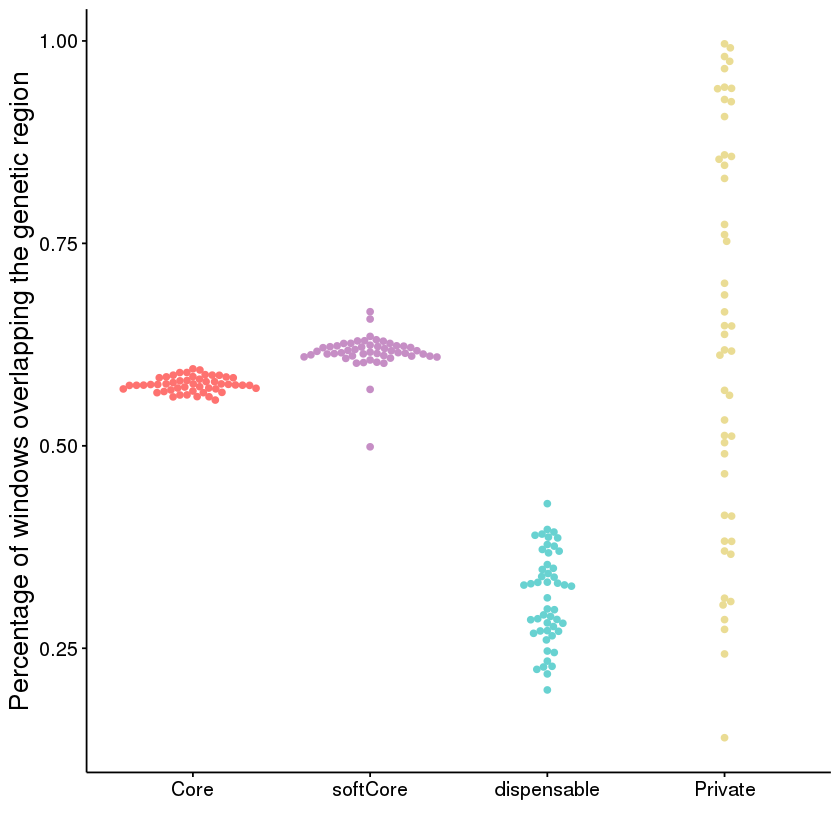

In [13]:
p=plotData %>% 
        filter(
                geneRegion == "containRatio"
        ) %>%
        ggplot(
                aes(x = windowType, y = seqRatio)
        ) +
        geom_beeswarm(
                mapping = aes(color = windowType),
                priority = "descending",
                dodge.width = 0,
                size = 1.5,
                show.legend = F
        ) +
        base_theme +
        theme(
                panel.grid = element_blank(),
                panel.background = element_blank(),
                axis.line = element_line(color='black'),
                axis.ticks = element_line(color='black'),
                axis.text = element_text(size=12)
        ) +
        xlab("") +
        ylab(
                "Percentage of windows overlapping the genetic region"
        )+scale_color_manual(
                values= c(
            "#fe7270",
            "#c68ec5",
            "#68d2d1",
            "#eadc94"
        ))
pdf("geneticRegionAnnotation/geneticOverlapRatio.pdf",width = 6,height = 6)
print(p)
dev.off()
p

### TODO A2和At在各自群体水平的多态性
> 首先我们将基因组划分为100Kb的windows，并统计每个windows在各自种内的PAV多态性情况
> 对于多态性值位于0-0.1的这些windows中，计算每个windows序列中属于syntenic和divergence序列的占比

In [6]:
library(ggplot2)
library(dplyr)
library(tidyr)

In [7]:
A2_At_50_windows_Pi=read.table(
    "./genome_100KbWindows_overlap_syntenicAndDivergence.txt",
    header = T,sep="\t"
)
#* 有的windows重复的被当成syntenic和divergence
A2_At_50_windows_Pi=A2_At_50_windows_Pi <- A2_At_50_windows_Pi %>%
    mutate(
        syntenicLen = ifelse(syntenicLen > 100000, 100000, syntenicLen)
    ) %>%
    mutate(
        diversityLen = ifelse(syntenicLen >= 100000, 0, diversityLen)
    )
head(A2_At_50_windows_Pi)

,Chr,start,end,Pi,Piclass,syntenicLen,diversityLen
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,HC04_A01,1,100001,0.994957983,0.20,74763,25248
2,HC04_A01,100000001,100100001,0.097575807,0.10,77637,39526
3,HC04_A01,10000001,10100001,0.004849399,0.02,70754,29249
4,HC04_A01,1000001,1100001,0.000000000,0.00,99974,29
5,HC04_A01,100001,200001,0.174400464,0.18,55678,51006
6,HC04_A01,100050001,100150001,0.104407349,0.12,65766,34240


In [8]:
syntenic=A2_At_50_windows_Pi %>% pivot_longer(
    cols = c("syntenicLen", "diversityLen"),
    names_to = "seqType",
    values_to = "seqLen"
    ) %>% filter(seqType=="syntenicLen")
divergence=A2_At_50_windows_Pi %>% pivot_longer(
    cols = c("syntenicLen", "diversityLen"),
    names_to = "seqType",
    values_to = "seqLen"
    ) %>% filter(seqType!="syntenicLen")
head(divergence)

Chr,start,end,Pi,Piclass,seqType,seqLen
<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>
HC04_A01,1,100001,0.994957983,0.20,diversityLen,25248
HC04_A01,100000001,100100001,0.097575807,0.10,diversityLen,39526
HC04_A01,10000001,10100001,0.004849399,0.02,diversityLen,29249
HC04_A01,1000001,1100001,0.000000000,0.00,diversityLen,29
HC04_A01,100001,200001,0.174400464,0.18,diversityLen,51006
HC04_A01,100050001,100150001,0.104407349,0.12,diversityLen,34240


In [9]:
plotData=A2_At_50_windows_Pi %>% pivot_longer(
    cols = c("syntenicLen", "diversityLen"),
    names_to = "seqType",
    values_to = "seqLen"
    ) %>% group_by(Piclass,seqType) %>% summarise(mean(seqLen))
colnames(plotData)=c("Piclass","seqType","seqLen")
plotData=as.data.frame(plotData)
plotData=plotData %>% filter(Piclass!=0)

`summarise()` has grouped output by 'Piclass'. You can override using the
`.groups` argument.


png 
  2

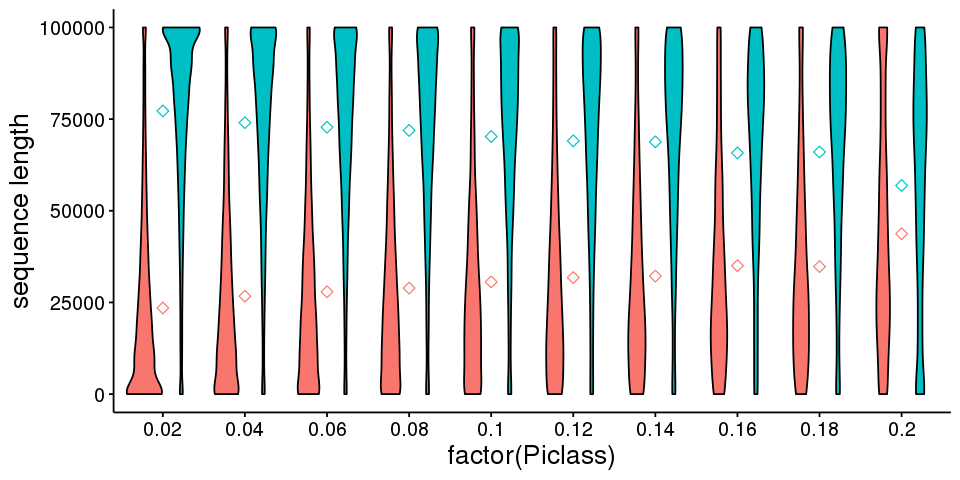

In [20]:
options(
    repr.plot.width = 8,
    repr.plot.height = 4
)
p=A2_At_50_windows_Pi %>%
    pivot_longer(
        cols = c("syntenicLen", "diversityLen"),
        names_to = "seqType",
        values_to = "seqLen"
    ) %>%
    filter(
        Piclass != 0
    ) %>%
    ggplot(
        aes(x = factor(Piclass), y = seqLen, fill = seqType)
    ) +
    geom_violin(
        color='black'
    )+
    geom_point(
        data=plotData,
        aes(x=factor(Piclass),y=seqLen,color=seqType),
        inherit.aes = F,
        shape=5,
        size=2
    )+base_theme +
    theme(
        panel.background = element_blank(),
        panel.grid = element_blank(),
        legend.position = "None"
    )+ylab(
        "sequence length"
    )
pdf("genomeWindows_overlapSynteny.pdf",width = 6,height = 3)
print(p)
dev.off()
p 

### TODO 统计每个材料中syntenic与divergence序列的累积长度
+ synteny region in A2
+ synteny region in At
+ divergence region in A2
+ divergence region in At

In [10]:
library(dplyr)
library(ggplot2)

In [50]:
A2=read.table(
    "/public/home/zpliu/Pan-genome/SV_parallele_V2/convergnce_divergence/A2_genomeAnnotate/A2_15_SampleSeq.txt",
    header = F
)
AD1=read.table(
    "/public/home/zpliu/Pan-genome/SV_parallele_V2/convergnce_divergence/AD1_genomeAnnotate/AD1_35_SampleSeq.txt",
    header = F
)
#* D基因组的序列长度信息
D5_Dt=read.table(
    "/public/home/zpliu/Pan-genome/SV_parallele_V2/GenomeCompare/D5_vs_Dt/AD1_genomeAnnotation/AD1_35_SampleSeq.txt",
    header = F
)


In [48]:
dim(plotData)

[1] 242   3

In [58]:
plotData <- rbind(
    A2, AD1,D5_Dt
)

plotData$V3 <- factor(
    plotData$V3,
    levels = c(
        "A2_syntenic", "At_syntenic", 
        "Dt_syntenic", "D5_syntenic","A2_divergence",
         "At_divergence", "Dt_divergence","D5_divergence"
    )
)
plotData %>% count(V3)

V3,n
<fct>,<int>
A2_syntenic,15
At_syntenic,35
Dt_syntenic,35
D5_syntenic,1
A2_divergence,15
At_divergence,35
Dt_divergence,35
D5_divergence,1


png 
  2

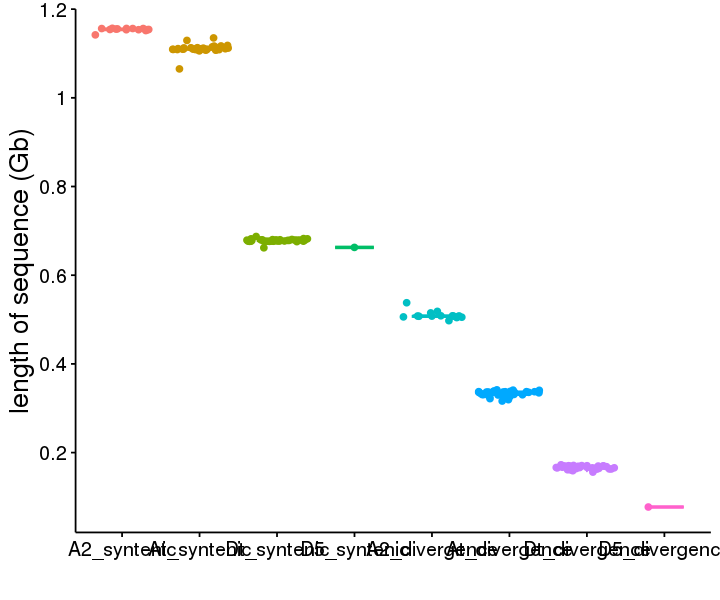

In [62]:
options(
    repr.plot.width=6,
    repr.plot.height=5
)

p=plotData %>% ggplot(
    aes(x = V3, y = V2,fill=V3,color=V3)
        ) +
    geom_boxplot(
        width=0.5,
        outlier.colour = NA
    )+geom_jitter(
         position = position_jitter(0.4)
    )+theme(
        legend.position = "none",
        panel.background = element_blank(),
        panel.grid = element_blank(),
        axis.title = element_blank()
    )+base_theme+
    scale_y_continuous(
        expand = c(0,0),
        limits = c(2e7,1.2e9),
        breaks = c(2e8,4e8,6e8,8e8,10e8,1.2e9),
        labels = c(0.2,0.4,0.6,0.8,1.0,1.2)
    )+
    ylab(
        "length of sequence (Gb)"
    )+xlab("")
pdf("sequenceLength_sample.pdf",width = 3,height = 3)
print(p)
dev.off()
p